Las implementaciones y los algoritmos para este método están ubicadas en la carpeta algorithms/trust_region, donde está el codigo de Dogleg para resolver el subproblema de encontrar la distancia p~k~  y minimizar la distancia dentro de la región de confianza

### Implementacion algoritmo Trust Region


Running with 2000 iterations


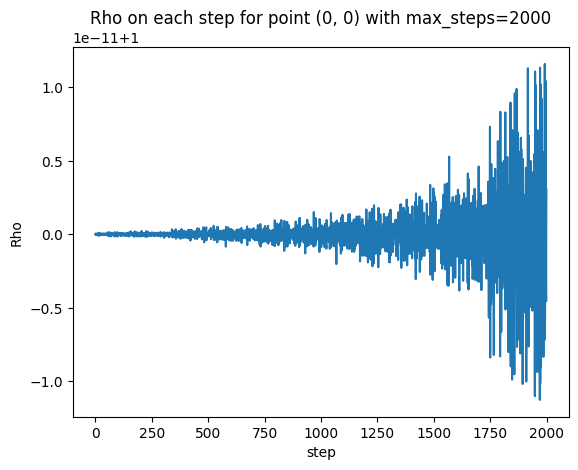

number of steps:  2000
Running with 3000 iterations


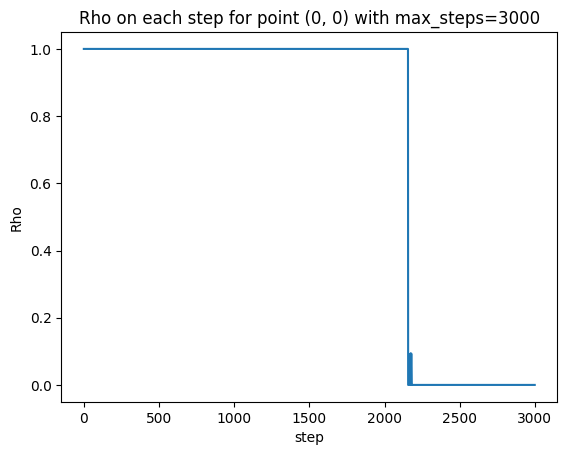

number of steps:  3000


array([1837.6068376 , 2606.83760684])

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from algorithms.trust_region import dogleg_method
from algorithms import functions

norm_p = dogleg_method.norm_p
f_provider = functions.FunctionProvider()

def approximate_model_generator(x, b_matrix):
    return lambda p: f_provider.f(*x) + np.dot(f_provider.grad(*x), p) + 0.5 * np.dot(np.dot(p, b_matrix), p)

# Parámetros globales
RHO_TOLERANCE = 1 / .000001
DELTA_HAT = 1.5
ETA = 1 / 5
EQUALITY_TOLERANCE = .000001

def trust_region(x, function_provider, subproblem_solver=dogleg_method.dog_leg, max_steps=2000, plot=False):
    global f_provider
    f_provider = function_provider
    delta = DELTA_HAT / 2 
    step = 0
    rho = RHO_TOLERANCE
    initial_x = x
    plot_y = []

    while step < max_steps and abs(rho) <= RHO_TOLERANCE:
        b_matrix = f_provider.hessian(*x)
        p = subproblem_solver(x, b_matrix, delta)
        approximate_model = approximate_model_generator(x, b_matrix)
        delta_f = f_provider.f(*x) - f_provider.f(*(x + p))  # Diferencia en el valor de la función
        delta_m = approximate_model(np.zeros(np.shape(x)[0])) - approximate_model(p)  # Diferencia en el valor del modelo aproximado

        if abs(delta_m) < 1e-8:
            delta_m = 1e-8
        
        rho = delta_f / delta_m
        
        if rho < .25:
            delta = .25 * delta
        else:
            if rho > .75 and abs(norm_p(p) - delta) < EQUALITY_TOLERANCE:
                delta = min(2 * delta, DELTA_HAT)

        if rho > ETA:
            x = x + p

        step += 1
        plot_y.append(rho)

    if plot:
        plt.title(f'Rho on each step for point ({initial_x[0]}, {initial_x[1]}) with max_steps={max_steps}')
        plt.ylabel('Rho')
        plt.xlabel('step')
        plt.plot(plot_y)
        plt.show()

    print('number of steps: ', step)
    return x

# Valores iniciales
x0 = np.array([0, 0])

# Eel método de región de confianza con 2000 iteraciones
print("Running with 2000 iterations")
trust_region(x0, dogleg_method.f_provider, subproblem_solver=dogleg_method.dog_leg, max_steps=2000, plot=True)

# el método de región de confianza con 3000 iteraciones
print("Running with 3000 iterations")
trust_region(x0, dogleg_method.f_provider, subproblem_solver=dogleg_method.dog_leg, max_steps=3000, plot=True)



### Rol de rho en el Código de Trust Region

En el método de Trust Region, rho es un parámetro clave que mide la calidad de la aproximación del modelo cuadrático en la región de confianza. rho se define como la razón entre la reducción real de la función objetivo y la reducción predicha por el modelo cuadrático.

Notemos que en este codigo, si variamos el número de iteraciones, vemos que las gráficas de cada uno de los casos es diferente. En la primera rho oscila de una manera abrupta 
a medida que va avanzando en las iteraciones, esto siguiere que el método está teniendo complicaciones lo que hace que el modelo cuadrático fluctúe, de este modo rho está oscilando en regiones de diferente curvatura y hace lque la precisión en los resultado se afecte. Sin embargo, para el caso de 3000 iteraciones vemos que pasadas las 2000 iteraciones decae a un valor 0 y se mantiene constante. Esto puede significar dos cosas:

1. El modelo cuadrático ya no es una buena aproximación de la función objetivo en la región actual
2. Puede haber una región en la que el método no está haciendo un buen progreso en la reducción de la función objetivo.

Por como vimos, el resultado óptimo se consigue pasadas las 2000 iteraciones según este modelo que estamos estudiando, por lo tanto podemos concluir que llegado a cierto punto, ya deja de progresar considerablemente el proceso de reducción de la función objetivo.


### Método De Gauss-Newton

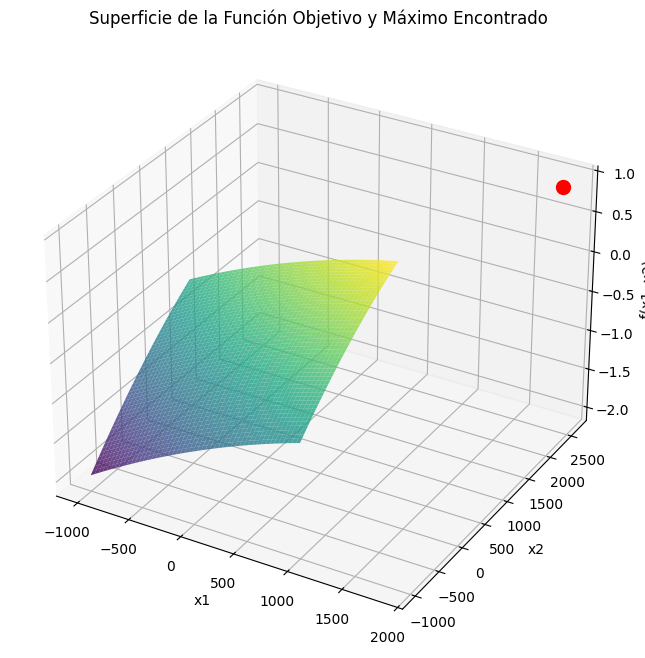

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Definir la función objetivo
def f(x1, x2):
    return (1250 - 0.1 * x1 - 0.03 * x2) * x1 + (1500 - 0.04 * x1 - 0.1 * x2) * x2 - (500000 + 700 * x1 + 850 * x2)


# Crear una malla de puntos
x1 = np.linspace(-1000, 1000, 400)
x2 = np.linspace(-1000, 1000, 400)
x1, x2 = np.meshgrid(x1, x2)
z = f(x1, x2)


# Encontrar el máximo usando el método de Gauss-Newton
def gradient(x):
    x1, x2 = x
    dfdx1 = 550 - 0.2 * x1 - 0.07 * x2
    dfdx2 = 650 - 0.07 * x1 - 0.2 * x2
    return np.array([dfdx1, dfdx2])


def jacobian(x):
    x1, x2 = x
    d2fdx1x1 = -0.2
    d2fdx1x2 = -0.07
    d2fdx2x2 = -0.2
    return np.array([[d2fdx1x1, d2fdx1x2], [d2fdx1x2, d2fdx2x2]])


def gauss_newton(x0, tol=1e-6, max_iter=100):
    x = x0
    for _ in range(max_iter):
        grad = gradient(x)
        J = jacobian(x)
        JtJ = J.T @ J
        Jt_grad = J.T @ grad

        try:
            delta = np.linalg.solve(JtJ, Jt_grad)
        except np.linalg.LinAlgError:
            print("Problema al resolver el sistema lineal.")
            return x

        x = x - delta  # Minimización

        if np.linalg.norm(delta) < tol:
            break

    return x


# Valor inicial
x0 = np.array([0, 0])

max_x = gauss_newton(x0)
max_value = f(max_x[0], max_x[1])

# Crear la figura y los ejes 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Superficie de la función
ax.plot_surface(x1, x2, z, cmap='viridis', alpha=0.8)

# Marcar el máximo encontrado
ax.scatter(max_x[0], max_x[1], max_value, color='r', s=100, label='Máximo Encontrado')

# Etiquetas y título
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('f(x1, x2)')
ax.set_title('Superficie de la Función Objetivo y Máximo Encontrado')

# Descomentar para agregar leyenda si necesario
# ax.legend(loc='upper right')  # Cambiar ubicación o eliminar si es innecesario

plt.show()



## Testeando los algoritmos para comparar las soluciones óptimas obtenidas.

#### Trust Region

In [68]:
optimized_x = trust_region(x0, dogleg_method.f_provider, subproblem_solver=dogleg_method.dog_leg,max_steps=3000, plot=False)
#Solucion:
print(f"Valores optimos: x1 = {optimized_x[0]}, x2 = {optimized_x[1]}")
print(f"Función evaluada en los valores óptimos: {f_provider.f(*optimized_x)}")


number of steps:  3000
Valores optimos: x1 = 1837.60683759977, x2 = 2606.8376068446664
Función evaluada en los valores óptimos: 852564.102564103


#### Gauss-Newton

In [69]:

print(f"Valores óptimos encontrados para el máximo: x1 = {max_x[0]}, x2 = {max_x[1]}")
print(f"Valor máximo de la función: {max_value}")

Valores óptimos encontrados para el máximo: x1 = 1837.6068376068372, x2 = 2606.8376068376074
Valor máximo de la función: 852564.1025641025


Si miramos el codigo de Gauss-Newton podemos aprecar que el resultado obtenido es el óptimo y el máximo de iteraciones fue de 100, lo cual nos hace concluir que el método de gauss-newton el cual es una modificación del método de Newton, es mucho mas eficiente y menos costoso computacionalmente hablando para lograr soluciones a este problema.